In [8]:
pip install musicbrainzngs

Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install dotenv

In [3]:
import os
import requests
import json
import base64
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import musicbrainzngs
import time
from tqdm import tqdm
from dotenv import load_dotenv

In [11]:
# Assigning lists and authorization to desired scopes:
#   users most listened to tracks: top
#    scope from documentation is 'user-top-read'
#   recently played by user: rp
#    scope from documentation is 'user-read-recently-played'

load_dotenv()

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

print(CLIENT_ID, CLIENT_SECRET)

top = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id='7eb3eb9606954d458388db9ff2945d9c',
    client_secret='e3fbfc18f5af4b4182c9b9ce9c096edb',
    redirect_uri='http://127.0.0.1:8889/callback',
    scope='user-top-read'
))

None None


In [30]:
# Pulling data and creating data frame for users' 50 most listened to tracks with information about artist, album, and popularity
# long_term = measured length of time
top_tracks = top.current_user_top_tracks(limit=50, time_range='long_term')

In [31]:
dict(top_tracks)

{'items': [{'album': {'album_type': 'single',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6ucHomyCWjxmvbyqAAbSci'},
      'href': 'https://api.spotify.com/v1/artists/6ucHomyCWjxmvbyqAAbSci',
      'id': '6ucHomyCWjxmvbyqAAbSci',
      'name': 'SAILORR',
      'type': 'artist',
      'uri': 'spotify:artist:6ucHomyCWjxmvbyqAAbSci'}],
    'available_markets': [],
    'external_urls': {'spotify': 'https://open.spotify.com/album/5nWBg995g3QcLrbLUPwxBC'},
    'href': 'https://api.spotify.com/v1/albums/5nWBg995g3QcLrbLUPwxBC',
    'id': '5nWBg995g3QcLrbLUPwxBC',
    'images': [{'height': 640,
      'url': 'https://i.scdn.co/image/ab67616d0000b2735e1d69f44c1151c44925bcb3',
      'width': 640},
     {'height': 300,
      'url': 'https://i.scdn.co/image/ab67616d00001e025e1d69f44c1151c44925bcb3',
      'width': 300},
     {'height': 64,
      'url': 'https://i.scdn.co/image/ab67616d000048515e1d69f44c1151c44925bcb3',
      'width': 64}],
    'is_playable': True,


In [34]:
# check 1
track_list = []
for item in top_tracks['items']:
    track_info = {
        'name': item['name'],
        'album': item['album']['name'],
        'artist': item['artists'][0]['name'],
        'popularity': item['popularity'], # "Based on a combination of the total number of plays a track has had, and how recent those plays are." 
        'track_id': item['id'],
        'genres': '', # adding empty 'genre' column for other API to be input here
        'MBID': '' # adding empty MBID column to be looked up in for MBrainz API to recall
    }
    track_list.append(track_info)

In [36]:
df_tracks = pd.DataFrame(track_list)
df_tracks

,name,album,artist,popularity,track_id,genres,MBID
0,POOKIE'S REQUIEM,POOKIE'S REQUIEM,SAILORR,21,0Cu1FFIqiLPHXDLCxTUUnR,,
1,CASH COBELLA CHOW COBIZZY,2 SLIZZY 2 SEXY (DELUXE),Cash Cobain,23,5Y2rV3zOArTzTYKVD1umBA,,
2,Telescope,Telescope,Hiatus Kaiyote,27,29oH20WCU0mVO3SwfIaaib,,
3,YEAH YEAH!,YEAH YEAH!,Eem Triplin,43,1spPgvtcDwxARDc8i6TYjT,,
4,smoke break,Animals Have Feelings,Samiyam,13,3ZHVUjAoLmwPCa2tTRfk2s,,
5,FRIENDZONE,FRIENDZONE,_BY.ALEXANDER,36,2CUWQEPhGo67JuDBng3jlN,,
6,WHERE YOU BEEN,Stay Safe,Foolie $urfin,21,5whMuC5R45eJ51iUGHKb4L,,
7,Sparkle Tape Break Up,Mood Valiant,Hiatus Kaiyote,41,2HkkI8s7wDYFls9pMEnxPi,,
8,On My Mama,On My Mama,Victoria Monét,66,1o8Z7GD1CeOaVBEyuzu4HO,,
9,007 (Jersey Mix),Chrome Bull DLX,Duckwrth,44,1qLBZLeGS6FEHgVKWqhuVv,,


In [38]:
### Adding musicbrainz for genres
# https://musicbrainz.org/doc/MusicBrainz_API
# python: https://python-musicbrainzngs.readthedocs.io/en/v0.7.1/usage/#

In [40]:
# Setting authorization
# https://musicbrainz.org/doc/MusicBrainz_API/Rate_Limiting#Provide_meaningful_User-Agent_strings
musicbrainzngs.set_useragent(
    "SpotifyProj",
    "0.1",
    "mtadesse@pratt.edu"
)

headers = {
    'User-Agent': 'SpotifyProj/1.0.0',
    'From': 'mtadesse@pratt.edu',
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

In [42]:
#### Cross-reference join: Exprting to .csv and looking up each MBID manually

In [44]:
df_tracks.to_csv('df_tracks.csv')

In [46]:
## Note: Artists with no 'genre' tags:
# SAILORR
# Cash Cobain
# _BY.ALEXANDER
# Foolie $urfin
# Leon Thomas
# Jordan Ward
# The Defaulters
# DESTIN CONRAD (tagged 'queer' lol)
# Merges
# Humble the Great
# Hello Yello
# Elysian Spring
# KHYA
# Kindness
# ((( O ))) (tagged 'sillyname')
# Wores G. Egziabher
# The Spy From Cairo

## Note: No MBID:
# Bonnie Calista NO
# Duhkey
# eLewminatti

In [48]:
# import new manually edited .csv to python
import csv

In [50]:
# Check 1 ('genres' column necessary?)
data = pd.read_csv('df_tracks_new.csv')

In [52]:
data

,name,album,artist,popularity,track_id,genres,MBID
0,POOKIE'S REQUIEM,POOKIE'S REQUIEM,SAILORR,23,0Cu1FFIqiLPHXDLCxTUUnR,NaN,b1a17965-b396-42e4-84f7-25d42b12f7c0
1,CASH COBELLA CHOW COBIZZY,2 SLIZZY 2 SEXY (DELUXE),Cash Cobain,23,5Y2rV3zOArTzTYKVD1umBA,NaN,4f57372b-2054-4722-a534-a99ab2598120
2,Telescope,Telescope,Hiatus Kaiyote,27,29oH20WCU0mVO3SwfIaaib,NaN,55c03773-59ea-4d4e-9057-87c2ecab005d
3,YEAH YEAH!,YEAH YEAH!,Eem Triplin,43,1spPgvtcDwxARDc8i6TYjT,NaN,c834075f-eecf-4c27-8276-d54fc2c0ed86
4,smoke break,Animals Have Feelings,Samiyam,13,3ZHVUjAoLmwPCa2tTRfk2s,NaN,6327bdfb-76b9-4a05-b447-01d98f1715dc
5,FRIENDZONE,FRIENDZONE,_BY.ALEXANDER,37,2CUWQEPhGo67JuDBng3jlN,NaN,03a81802-28fb-4733-a506-132886e40ed5
6,WHERE YOU BEEN,Stay Safe,Foolie $urfin,21,5whMuC5R45eJ51iUGHKb4L,NaN,6c59e924-22f5-4534-8975-a3fef0ab4d4a
7,Sparkle Tape Break Up,Mood Valiant,Hiatus Kaiyote,41,2HkkI8s7wDYFls9pMEnxPi,NaN,55c03773-59ea-4d4e-9057-87c2ecab005d
8,On My Mama,On My Mama,Victoria Monét,66,1o8Z7GD1CeOaVBEyuzu4HO,NaN,28d83274-26ab-4a6a-b9ff-340f4784e7dd
9,007 (Jersey Mix),Chrome Bull DLX,Duckwrth,44,1qLBZLeGS6FEHgVKWqhuVv,NaN,2bc82618-2d0f-436e-adb2-8aa0774dd799


In [54]:
## Trying to turn into dictionary or list

In [56]:
data_listed = data.to_dict('records')

In [58]:
data_dicted = data.to_dict()

In [60]:
mbid_list = []
for item in data_listed:
    mbid_list.append(item['MBID'])

In [62]:
# Check 2
mbid_dict = data_dicted['MBID']

In [64]:
####### YES YES YES GOOD THIS WORKED GETTING IT. CODEWORD: START
## "Iterate list on query string element by element"
# https://stackoverflow.com/questions/68203611/iterate-list-on-query-string-element-by-element

In [66]:
base_url = 'https://musicbrainz.org/ws/2/'
path = 'artist/'
tag = 'inc=genres&fmt=json'

prod_list = []
for item in mbid_list:
    time.sleep(1)
    r = requests.get(f'{base_url}{path}{item}?{tag}', headers=headers)
    parsed = r.json()
    prod_list.append(parsed)

In [67]:
prod_list[0].keys()

dict_keys(['gender', 'name', 'isnis', 'area', 'life-span', 'ipis', 'end-area', 'country', 'begin-area', 'sort-name', 'type-id', 'genres', 'type', 'gender-id', 'disambiguation', 'id'])

In [68]:
for item in prod_list:
    print(item['genres'])

[]
[]
[{'id': '286f9168-9c46-4e41-94a1-1aa4aeb93b8c', 'disambiguation': '', 'name': 'neo soul', 'count': 1}, {'disambiguation': '', 'id': '31be54b2-4d0c-42df-aa44-c496c7b4c3c3', 'count': 1, 'name': 'r&b'}]
[{'count': 1, 'name': 'hip hop', 'disambiguation': '', 'id': '52faa157-6bad-4d86-a0ab-d4dec7d2513c'}, {'name': 'trap', 'count': 1, 'id': '9a339aa8-a0e5-450c-95a7-b11517bb508f', 'disambiguation': ''}]
[{'name': 'hip hop', 'disambiguation': '', 'id': '52faa157-6bad-4d86-a0ab-d4dec7d2513c', 'count': 1}]
[]
[]
[{'id': '286f9168-9c46-4e41-94a1-1aa4aeb93b8c', 'disambiguation': '', 'name': 'neo soul', 'count': 1}, {'count': 1, 'name': 'r&b', 'disambiguation': '', 'id': '31be54b2-4d0c-42df-aa44-c496c7b4c3c3'}]
[{'name': 'alternative r&b', 'count': 1, 'id': '4e03fb35-d571-4111-824d-88c9f8a3d0c9', 'disambiguation': ''}, {'id': 'fe4ba6a1-9873-4fd0-a12b-a70c81818514', 'disambiguation': '', 'name': 'funk', 'count': 1}, {'id': '911c7bbb-172d-4df8-9478-dbff4296e791', 'disambiguation': '', 'name': '

KeyError: 'genres'

In [38]:
# listing the artist names (n1) and genres names (good1) in order as nested lists
genre_tag = []
name_tag = []

for item in prod_list:
    get_name = item.get('name')  # returns None if 'name' doesn't exist
    name_tag.append(get_name)
    
    get_genre = item.get('genres', [])  # empty list if missing
    get_names = [genre.get('name') for genre in get_genre if 'name' in genre]
    genre_tag.append(get_names)

In [40]:
data['genres'] = genre_tag

In [42]:
data.rename(columns={'name': 'song name'}, inplace=True)

In [44]:
numbers = list(range(1, 51))

In [46]:
data['rank'] = numbers

In [48]:
data = data.loc[:, ['rank', 'artist', 'song name', 'genres', 'album', 'popularity', 'track_id', 'MBID']] # reordering for visual clarity

In [223]:
data

,rank,artist,song name,genres,album,popularity,track_id,MBID,num_genres,weight
0,1,SAILORR,POOKIE'S REQUIEM,[],POOKIE'S REQUIEM,23,0Cu1FFIqiLPHXDLCxTUUnR,b1a17965-b396-42e4-84f7-25d42b12f7c0,0,1.000000
1,2,Cash Cobain,CASH COBELLA CHOW COBIZZY,[],2 SLIZZY 2 SEXY (DELUXE),23,5Y2rV3zOArTzTYKVD1umBA,4f57372b-2054-4722-a534-a99ab2598120,0,1.000000
2,3,Hiatus Kaiyote,Telescope,"[neo soul, r&b]",Telescope,27,29oH20WCU0mVO3SwfIaaib,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000
3,4,Eem Triplin,YEAH YEAH!,"[hip hop, trap]",YEAH YEAH!,43,1spPgvtcDwxARDc8i6TYjT,c834075f-eecf-4c27-8276-d54fc2c0ed86,2,0.500000
4,5,Samiyam,smoke break,[hip hop],Animals Have Feelings,13,3ZHVUjAoLmwPCa2tTRfk2s,6327bdfb-76b9-4a05-b447-01d98f1715dc,1,1.000000
5,6,_BY.ALEXANDER,FRIENDZONE,[],FRIENDZONE,37,2CUWQEPhGo67JuDBng3jlN,03a81802-28fb-4733-a506-132886e40ed5,0,1.000000
6,7,Foolie $urfin,WHERE YOU BEEN,[],Stay Safe,21,5whMuC5R45eJ51iUGHKb4L,6c59e924-22f5-4534-8975-a3fef0ab4d4a,0,1.000000
7,8,Hiatus Kaiyote,Sparkle Tape Break Up,"[neo soul, r&b]",Mood Valiant,41,2HkkI8s7wDYFls9pMEnxPi,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000
8,9,Victoria Monét,On My Mama,"[alternative r&b, funk, pop, r&b, soul]",On My Mama,66,1o8Z7GD1CeOaVBEyuzu4HO,28d83274-26ab-4a6a-b9ff-340f4784e7dd,5,0.200000
9,10,Duckwrth,007 (Jersey Mix),"[alternative r&b, trap soul]",Chrome Bull DLX,44,1qLBZLeGS6FEHgVKWqhuVv,2bc82618-2d0f-436e-adb2-8aa0774dd799,2,0.500000


In [471]:
### Changing genres from list[list] to duplicating values with multiple genres... need to weight

In [50]:
data['num_genres'] = data['genres'].apply(len)
data['weight'] = data['num_genres'].apply(lambda x: 1/x if x > 0 else 1)

In [233]:
exploded_data = data.explode('genres').reset_index(drop=True) # duplicating rows with multiple genres so its no longer list[list]
exploded_data = exploded_data.rename(columns={'genres': 'genre'})
exploded_data['genre'] = exploded_data['genre'].fillna(' ') # removing [] and '0' with just blanks

In [235]:
exploded_data

,rank,artist,song name,genre,album,popularity,track_id,MBID,num_genres,weight
0,1,SAILORR,POOKIE'S REQUIEM,,POOKIE'S REQUIEM,23,0Cu1FFIqiLPHXDLCxTUUnR,b1a17965-b396-42e4-84f7-25d42b12f7c0,0,1.000000
1,2,Cash Cobain,CASH COBELLA CHOW COBIZZY,,2 SLIZZY 2 SEXY (DELUXE),23,5Y2rV3zOArTzTYKVD1umBA,4f57372b-2054-4722-a534-a99ab2598120,0,1.000000
2,3,Hiatus Kaiyote,Telescope,neo soul,Telescope,27,29oH20WCU0mVO3SwfIaaib,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000
3,3,Hiatus Kaiyote,Telescope,r&b,Telescope,27,29oH20WCU0mVO3SwfIaaib,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000
4,4,Eem Triplin,YEAH YEAH!,hip hop,YEAH YEAH!,43,1spPgvtcDwxARDc8i6TYjT,c834075f-eecf-4c27-8276-d54fc2c0ed86,2,0.500000
...,...,...,...,...,...,...,...,...,...,...
127,50,Beyoncé,Green Light,pop rap,B'Day Deluxe Edition,53,3JdDBUiZ1UJv7J7RQqxEFF,859d0860-d480-4efd-970c-c05d5f1776b8,12,0.083333
128,50,Beyoncé,Green Light,pop soul,B'Day Deluxe Edition,53,3JdDBUiZ1UJv7J7RQqxEFF,859d0860-d480-4efd-970c-c05d5f1776b8,12,0.083333
129,50,Beyoncé,Green Light,progressive house,B'Day Deluxe Edition,53,3JdDBUiZ1UJv7J7RQqxEFF,859d0860-d480-4efd-970c-c05d5f1776b8,12,0.083333
130,50,Beyoncé,Green Light,r&b,B'Day Deluxe Edition,53,3JdDBUiZ1UJv7J7RQqxEFF,859d0860-d480-4efd-970c-c05d5f1776b8,12,0.083333


In [76]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import to_rgb, to_hex
import colorsys

In [ ]:
#  Visualization: Moods 3D Plot
## x = happiness
## y = energy
## z = danceability
## color = genre-group
## symbol = explicit (1) vs not explcit (0)

In [86]:
condensed_data.to_csv('condensed.csv')

In [97]:
mood_data = pd.read_csv('condensed_new.csv')

In [123]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
mood_data['genre_numeric'] = label_encoder.fit_transform(mood_data['genre_group'])

In [322]:
mood_data['Explicit Tag'] = mood_data['explicit'].map({1: 'Explicit', 0: 'Clean'})
symbol_tags = {
    'Explicit': 'cross',
    'Clean': 'circle'
}

m1 = px.scatter_3d(
    mood_data,
    x='happiness',
    y='energy',
    z='danceability',
    color='genre_numeric',
    color_continuous_scale='spectral', 
    hover_data=['song name', 'artist', 'genres', 'genre_group'],
    symbol='Explicit Tag',
    symbol_map=symbol_tags,
    title='Mood: 3D Audio Features'
)

m1.update_traces(marker=dict(size=5, opacity=1))
m1.update_layout(
    scene=dict(
        # Text + Labels
        xaxis_title='Happiness',
        yaxis_title='Energy',
        zaxis_title='Danceability',
        bgcolor='black'
    ),
    # Background
    paper_bgcolor='black',
    plot_bgcolor='white',
    font=dict(color='white'),
    height=700,
    width=900,
    )

m1.show()

In [324]:
mood_data

,Unnamed: 0,rank,artist,song name,genres,album,explicit,energy,danceability,happiness,popularity,track_id,MBID,num_genres,weight,genre_group,genre_numeric,symbol,Explicit Tag
0,0,1,SAILORR,POOKIE'S REQUIEM,r&b,POOKIE'S REQUIEM,1,70,50,66,23,0Cu1FFIqiLPHXDLCxTUUnR,b1a17965-b396-42e4-84f7-25d42b12f7c0,0,1.000000,R&B + Soul,5,Explicit,Explicit
1,1,2,Cash Cobain,CASH COBELLA CHOW COBIZZY,hip hop,2 SLIZZY 2 SEXY (DELUXE),1,60,65,53,23,5Y2rV3zOArTzTYKVD1umBA,4f57372b-2054-4722-a534-a99ab2598120,0,1.000000,"Hip-Hop, Rap",1,Explicit,Explicit
2,2,3,Hiatus Kaiyote,Telescope,"neo soul, r&b",Telescope,0,64,72,70,27,29oH20WCU0mVO3SwfIaaib,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000,R&B + Soul,5,Clean,Clean
3,3,4,Eem Triplin,YEAH YEAH!,"hip hop, trap",YEAH YEAH!,1,48,46,30,43,1spPgvtcDwxARDc8i6TYjT,c834075f-eecf-4c27-8276-d54fc2c0ed86,2,0.500000,"Hip-Hop, Rap",1,Explicit,Explicit
4,4,5,Samiyam,smoke break,hip hop,Animals Have Feelings,0,54,42,45,13,3ZHVUjAoLmwPCa2tTRfk2s,6327bdfb-76b9-4a05-b447-01d98f1715dc,1,1.000000,"Hip-Hop, Rap",1,Clean,Clean
5,5,6,_BY.ALEXANDER,FRIENDZONE,alternative r&b,FRIENDZONE,0,68,47,46,37,2CUWQEPhGo67JuDBng3jlN,03a81802-28fb-4733-a506-132886e40ed5,0,1.000000,R&B + Soul,5,Clean,Clean
6,6,7,Foolie $urfin,WHERE YOU BEEN,experimental rap,Stay Safe,1,76,50,50,21,5whMuC5R45eJ51iUGHKb4L,6c59e924-22f5-4534-8975-a3fef0ab4d4a,0,1.000000,"Hip-Hop, Rap",1,Explicit,Explicit
7,7,8,Hiatus Kaiyote,Sparkle Tape Break Up,"neo soul, r&b",Mood Valiant,0,63,63,45,41,2HkkI8s7wDYFls9pMEnxPi,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000,R&B + Soul,5,Clean,Clean
8,8,9,Victoria Monét,On My Mama,"alternative r&b, funk, pop, r&b, soul",On My Mama,1,55,68,70,66,1o8Z7GD1CeOaVBEyuzu4HO,28d83274-26ab-4a6a-b9ff-340f4784e7dd,5,0.200000,R&B + Soul,5,Explicit,Explicit
9,9,10,Duckwrth,007 (Jersey Mix),"alternative r&b, trap soul",Chrome Bull DLX,1,71,39,69,44,1qLBZLeGS6FEHgVKWqhuVv,2bc82618-2d0f-436e-adb2-8aa0774dd799,2,0.500000,R&B + Soul,5,Explicit,Explicit


In [ ]:
## Mood Heatmap

In [255]:
import plotly.express as px
import xarray as xr

In [269]:
mood_data

,Unnamed: 0,rank,artist,song name,genres,album,explicit,energy,danceability,happiness,popularity,track_id,MBID,num_genres,weight,genre_group,genre_numeric,symbol,Explicit Tag
0,0,1,SAILORR,POOKIE'S REQUIEM,r&b,POOKIE'S REQUIEM,1,70,50,66,23,0Cu1FFIqiLPHXDLCxTUUnR,b1a17965-b396-42e4-84f7-25d42b12f7c0,0,1.000000,R&B + Soul,5,Explicit,Explicit
1,1,2,Cash Cobain,CASH COBELLA CHOW COBIZZY,hip hop,2 SLIZZY 2 SEXY (DELUXE),1,60,65,53,23,5Y2rV3zOArTzTYKVD1umBA,4f57372b-2054-4722-a534-a99ab2598120,0,1.000000,"Hip-Hop, Rap",1,Explicit,Explicit
2,2,3,Hiatus Kaiyote,Telescope,"neo soul, r&b",Telescope,0,64,72,70,27,29oH20WCU0mVO3SwfIaaib,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000,R&B + Soul,5,Clean,Clean
3,3,4,Eem Triplin,YEAH YEAH!,"hip hop, trap",YEAH YEAH!,1,48,46,30,43,1spPgvtcDwxARDc8i6TYjT,c834075f-eecf-4c27-8276-d54fc2c0ed86,2,0.500000,"Hip-Hop, Rap",1,Explicit,Explicit
4,4,5,Samiyam,smoke break,hip hop,Animals Have Feelings,0,54,42,45,13,3ZHVUjAoLmwPCa2tTRfk2s,6327bdfb-76b9-4a05-b447-01d98f1715dc,1,1.000000,"Hip-Hop, Rap",1,Clean,Clean
5,5,6,_BY.ALEXANDER,FRIENDZONE,alternative r&b,FRIENDZONE,0,68,47,46,37,2CUWQEPhGo67JuDBng3jlN,03a81802-28fb-4733-a506-132886e40ed5,0,1.000000,R&B + Soul,5,Clean,Clean
6,6,7,Foolie $urfin,WHERE YOU BEEN,experimental rap,Stay Safe,1,76,50,50,21,5whMuC5R45eJ51iUGHKb4L,6c59e924-22f5-4534-8975-a3fef0ab4d4a,0,1.000000,"Hip-Hop, Rap",1,Explicit,Explicit
7,7,8,Hiatus Kaiyote,Sparkle Tape Break Up,"neo soul, r&b",Mood Valiant,0,63,63,45,41,2HkkI8s7wDYFls9pMEnxPi,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000,R&B + Soul,5,Clean,Clean
8,8,9,Victoria Monét,On My Mama,"alternative r&b, funk, pop, r&b, soul",On My Mama,1,55,68,70,66,1o8Z7GD1CeOaVBEyuzu4HO,28d83274-26ab-4a6a-b9ff-340f4784e7dd,5,0.200000,R&B + Soul,5,Explicit,Explicit
9,9,10,Duckwrth,007 (Jersey Mix),"alternative r&b, trap soul",Chrome Bull DLX,1,71,39,69,44,1qLBZLeGS6FEHgVKWqhuVv,2bc82618-2d0f-436e-adb2-8aa0774dd799,2,0.500000,R&B + Soul,5,Explicit,Explicit


In [ ]:
## Genre clustering and ranking Heat Map

In [56]:
genre_grouping = {
    'Indie, Lo-Fi' : ['lo-fi', 'chillwave', 'instrumental', 'hypnagogic pop', 'indie pop'],
    'R&B + Soul': ['neo soul', 'pop soul', 'soul', 'r&b', 'alternative r&b', 'contemporary r&b', 'hip hop soul', 'trap soul'],
    'Jazz + Blues': ['jazz', 'nu jazz', 'african blues'],
    'Hip-Hop, Rap': ['boom bap', 'pop rap', 'cloud rap', 'experimental hip hop', 'hip hop', 'trap', 'instrumental hip hop', 'lo-fi hip hop'],
    'Funk, House, Dance': ['acid jazz','dance', 'disco', 'house', 'progressive house', 'deep house', 'downtempo', 'funk', 'electronic', 'electronica'],
    'Pop': ['dance-pop', 'pop rock', 'alternative pop', 'art pop', 'bedroom pop', 'electropop', 'pop'],
    'Other': ['singer-songwriter', 'rage', 'synth-pop']
}

In [58]:
### Condensing genres
condensed_data = data.copy()
condensed_data['genres'] = condensed_data['genres'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else ''
)

In [60]:
# Creating subgenres
genre_map = {
    subgenre: group
    for group, subgenres in genre_grouping.items()
    for subgenre in subgenres
}

In [64]:
## Manual assignment of unassigned genres
manual_assignments = {
    "POOKIE'S REQUIEM": ('r&b', 'R&B + Soul'),
    'CASH COBELLA CHOW COBIZZY': ('hip hop', 'Hip-Hop, Rap'),
    'FRIENDZONE': ('alternative r&b', 'R&B + Soul'),
    'WHERE YOU BEEN': ('experimental rap','Hip-Hop, Rap'),
    'DANCING WITH DEMONS': ('contemporary r&b', 'R&B + Soul'),
    'WHITE CROCS (with Ryan Trey)': ('pop rap', 'Hip-Hop, Rap'),
    '311 (with Gwen Bunn)': ('alternative r&b', 'R&B + Soul'),
    'Gentle Man': ('soul', 'R&B + Soul'),
    'LUV N DEVOTION': ('dance reggae', 'Funk, House, Dance'),
    'YES IT IS': ('contemporary r&b', 'R&B + Soul'),
    'CHERIMOYA - BONUS': ('hip hop soul', 'R&B + Soul'),
    'Nafas': ('nu jazz', 'Jazz + Blues'),
    'Abo Yiba': ('african blues', 'Jazz + Blues'),
    'Wrong Way': ('electronic', 'Funk, House, Dance'),
    'With You': ('alternative indie', 'Indie, Lo-Fi'),
    'HOW FAST': ('contemporary r&b', 'R&B + Soul'),
    "MARY'S STRAIN 144BPM": ('house', 'Funk, House, Dance'),
    'She Got Dat': ('bass rap', 'Hip-Hop, Rap'),
    'Blue Sands': ('jazz', 'Jazz + Blues'),
    'Moon interlude': ('hypnagogic pop', 'Indie, Lo-Fi'),
    '495': ('pop rap', 'Hip-Hop, Rap'),
    'Alone In December': ('pop rock', 'Pop'),
    'Good Intentions': ('pop rock', 'Pop'),
    'u.': ('indie pop', 'Indie, Lo-Fi'),
    'cool_v2': ('lo-fi', 'Indie, Lo-Fi'),
    'Sunday Eve, Baby': ('hypnagogic pop', 'Indie, Lo-Fi')
}

In [66]:
# converting genres into strings
condensed_data['genre_group'] = condensed_data['genres'].str.lower().map(genre_grouping)

In [68]:
## Applying genre groupings into column
def get_genre_group(genres_str):
    if not isinstance(genres_str, str):
        return ''
    for genre in genres_str.split(', '):
        if genre in genre_map:
            return genre_map[genre]
    return ''

condensed_data['genre_group'] = condensed_data['genres'].apply(get_genre_group)

In [70]:
## Applying manually assigned genres list to column
for song, (genre, group) in manual_assignments.items():
    condensed_data.loc[condensed_data['song name'] == song, 'genres'] = genre,
    condensed_data.loc[condensed_data['song name'] == song, 'genre_group'] = group

In [72]:
condensed_data

,rank,artist,song name,genres,album,popularity,track_id,MBID,num_genres,weight,genre_group
0,1,SAILORR,POOKIE'S REQUIEM,r&b,POOKIE'S REQUIEM,23,0Cu1FFIqiLPHXDLCxTUUnR,b1a17965-b396-42e4-84f7-25d42b12f7c0,0,1.000000,R&B + Soul
1,2,Cash Cobain,CASH COBELLA CHOW COBIZZY,hip hop,2 SLIZZY 2 SEXY (DELUXE),23,5Y2rV3zOArTzTYKVD1umBA,4f57372b-2054-4722-a534-a99ab2598120,0,1.000000,"Hip-Hop, Rap"
2,3,Hiatus Kaiyote,Telescope,"neo soul, r&b",Telescope,27,29oH20WCU0mVO3SwfIaaib,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000,R&B + Soul
3,4,Eem Triplin,YEAH YEAH!,"hip hop, trap",YEAH YEAH!,43,1spPgvtcDwxARDc8i6TYjT,c834075f-eecf-4c27-8276-d54fc2c0ed86,2,0.500000,"Hip-Hop, Rap"
4,5,Samiyam,smoke break,hip hop,Animals Have Feelings,13,3ZHVUjAoLmwPCa2tTRfk2s,6327bdfb-76b9-4a05-b447-01d98f1715dc,1,1.000000,"Hip-Hop, Rap"
5,6,_BY.ALEXANDER,FRIENDZONE,alternative r&b,FRIENDZONE,37,2CUWQEPhGo67JuDBng3jlN,03a81802-28fb-4733-a506-132886e40ed5,0,1.000000,R&B + Soul
6,7,Foolie $urfin,WHERE YOU BEEN,experimental rap,Stay Safe,21,5whMuC5R45eJ51iUGHKb4L,6c59e924-22f5-4534-8975-a3fef0ab4d4a,0,1.000000,"Hip-Hop, Rap"
7,8,Hiatus Kaiyote,Sparkle Tape Break Up,"neo soul, r&b",Mood Valiant,41,2HkkI8s7wDYFls9pMEnxPi,55c03773-59ea-4d4e-9057-87c2ecab005d,2,0.500000,R&B + Soul
8,9,Victoria Monét,On My Mama,"alternative r&b, funk, pop, r&b, soul",On My Mama,66,1o8Z7GD1CeOaVBEyuzu4HO,28d83274-26ab-4a6a-b9ff-340f4784e7dd,5,0.200000,R&B + Soul
9,10,Duckwrth,007 (Jersey Mix),"alternative r&b, trap soul",Chrome Bull DLX,44,1qLBZLeGS6FEHgVKWqhuVv,2bc82618-2d0f-436e-adb2-8aa0774dd799,2,0.500000,R&B + Soul


In [78]:
base_colors = { 
    'R&B + Soul': '#ffffff', 
    'Hip-Hop, Rap': '#f0f921',
    'Funk, House, Dance': '#fb9f3a',  
    'Jazz + Blues': '#fb0b0c',     
    'Pop': '#9c179e',
    'Indie, Lo-Fi': '#511cfb',
    'Other': '#7f7f7f'   
}

def get_shades(base_colors, num_shades):
    base_rgb = to_rgb(base_colors)
    h, l, s = colorsys.rgb_to_hls(*base_rgb)
    return [to_hex(colorsys.hls_to_rgb(h, min(1, l + 0.1 * i), s)) for i in range(num_shades)]

custom_colors = {}
for group, subgenres in genre_grouping.items():
    shades = get_shades(base_colors[group], len(subgenres))
    for subgenre, shade in zip(subgenres, shades):
        custom_colors[subgenre] = shade

In [80]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(2, 35))

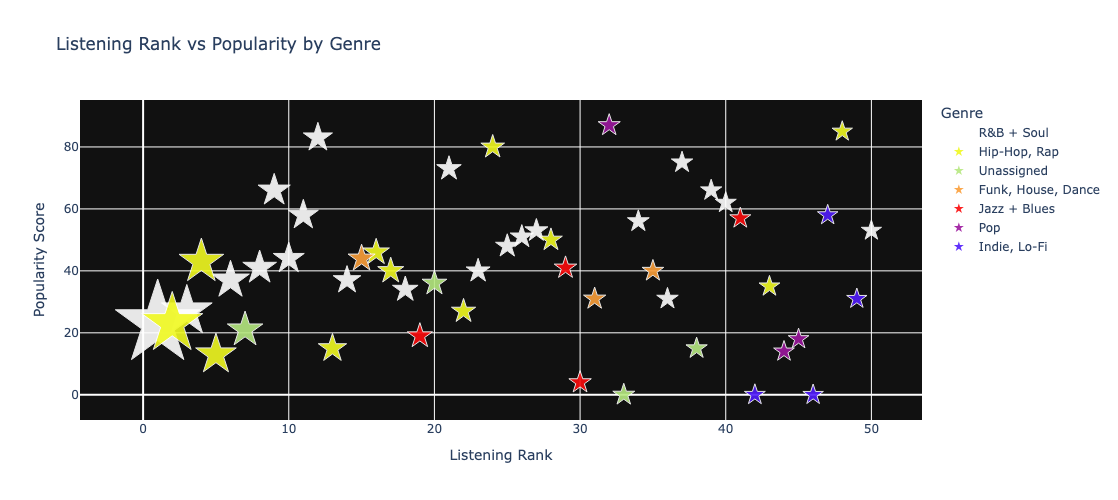

In [308]:
### BOOKMARK 2: GRAPH BY GENRE
## Good graph 1: scaled + manually assigned genres
scaled_size = scaler.fit_transform(1 / condensed_data['rank'].values.reshape(-1, 1)).flatten()

fig = px.scatter(
    condensed_data,
    x='rank',
    y='popularity',
    color='genre_group',
    color_discrete_map=base_colors,
    title='Listening Rank vs Popularity by Genre',
    size=scaled_size,
    size_max=45
)

fig.update_traces(marker=dict(opacity=0.9, symbol='star'), selector=dict(mode='markers'))
fig.update_layout(
    plot_bgcolor='#111111',
    xaxis_title='Listening Rank',
    yaxis_title='Popularity Score',
    legend_title='Genre',
    height=500,
    width=1000
)

fig.show()

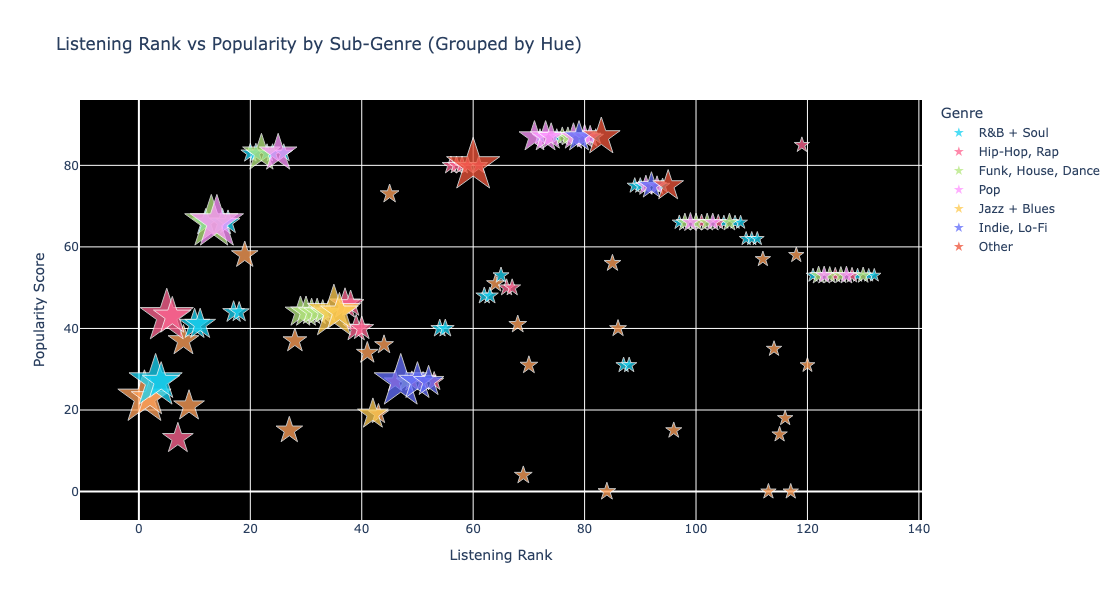

In [249]:
### BOOKMARK 3: Exploded Data 
## Exploded data: multiple entries for tracks based on genres
fig = px.scatter(
    exploded_data,
    x=exploded_data.index + 1,
    y='popularity',
    color='genre_group',
    color_discrete_map=custom_colors,
    size=inverse_size,
    hover_data=['song name', 'artist', 'genre'],
    title='Listening Rank vs Popularity by Sub-Genre (Grouped by Hue)'
)

fig.update_traces(marker=dict(opacity=0.77, symbol='star', size=inverse_size,
        sizemode='area',
        sizeref=2.*max(inverse_size)/(40.**2),
        sizemin=4), selector=dict(mode='markers'))
fig.update_layout(
    plot_bgcolor='black',
    xaxis_title='Listening Rank',
    yaxis_title='Popularity Score',
    legend_title='Genre',
    height=600,
    width=1000
)

fig.show()

In [ ]:
#### Some Tests and draft code:

In [ ]:
test_name_genre = pd.DataFrame ({
    'artist name': name_tag,
    'genre tags': genre_tag
})

In [564]:
headers = {
    'User-Agent': 'SpotifyProj/1.0.0',
    'From': 'mtadesse@pratt.edu'
}

In [30]:
## base_url, path, query
# /<genre>/<MBID>?inc=<INC>
headers = {
    'User-Agent': 'SpotifyProj/1.0.0',
    'From': 'mtadesse@pratt.edu'  # This is another valid field
}

test_url = 'https://musicbrainz.org/ws/2/' # root
test_path = 'artist/' # folder
test_query = '55c03773-59ea-4d4e-9057-87c2ecab005d?'
tag = 'inc=genres&fmt=json'

r_test = requests.get(f'{test_url}{test_path}{test_query}{tag}', headers=headers)

In [32]:
parsed_test = r_test.json()

In [578]:
parsed_test.keys()

dict_keys(['sort-name', 'isnis', 'begin-area', 'gender-id', 'end-area', 'genres', 'ipis', 'type', 'area', 'name', 'country', 'gender', 'disambiguation', 'life-span', 'id', 'type-id'])

In [34]:
parsed_test['genres'][0].keys()

dict_keys(['count', 'name', 'disambiguation', 'id'])

In [36]:
dict(parsed_test['genres'][1])

{'count': 1,
 'name': 'r&b',
 'disambiguation': '',
 'id': '31be54b2-4d0c-42df-aa44-c496c7b4c3c3'}

In [38]:
parsed_test

{'ipis': [],
 'life-span': {'end': None, 'begin': '2011', 'ended': False},
 'type-id': 'e431f5f6-b5d2-343d-8b36-72607fffb74b',
 'begin-area': {'type-id': None,
  'sort-name': 'Melbourne',
  'id': 'b4e9352c-8edf-4911-8fa3-e852afa30501',
  'disambiguation': '',
  'type': None,
  'name': 'Melbourne'},
 'sort-name': 'Hiatus Kaiyote',
 'country': 'AU',
 'end-area': None,
 'name': 'Hiatus Kaiyote',
 'gender': None,
 'isnis': ['0000000469293024'],
 'area': {'sort-name': 'Australia',
  'id': '106e0bec-b638-3b37-b731-f53d507dc00e',
  'disambiguation': '',
  'type-id': None,
  'type': None,
  'iso-3166-1-codes': ['AU'],
  'name': 'Australia'},
 'gender-id': None,
 'type': 'Group',
 'id': '55c03773-59ea-4d4e-9057-87c2ecab005d',
 'disambiguation': 'Australian neo‐soul group',
 'genres': [{'count': 1,
   'name': 'neo soul',
   'disambiguation': '',
   'id': '286f9168-9c46-4e41-94a1-1aa4aeb93b8c'},
  {'count': 1,
   'name': 'r&b',
   'disambiguation': '',
   'id': '31be54b2-4d0c-42df-aa44-c496c7b4c3

In [40]:
# Check 4: Do I need genre_names for anything outside of test (Makeda from future says Yes)?
test_genre = [genre['name'] for genre in parsed_test['genres']]

In [42]:
test_genre

['neo soul', 'r&b']

In [44]:
test_names = parsed_test['sort-name']

In [46]:
test_names

'Hiatus Kaiyote'

In [48]:
test_list = {
    'name': [test_names], 
    'genre': [test_genre]
}

In [50]:
parsed_test['genres']

[{'count': 1,
  'name': 'neo soul',
  'disambiguation': '',
  'id': '286f9168-9c46-4e41-94a1-1aa4aeb93b8c'},
 {'count': 1,
  'name': 'r&b',
  'disambiguation': '',
  'id': '31be54b2-4d0c-42df-aa44-c496c7b4c3c3'}]

In [54]:
test_list

{'name': ['Hiatus Kaiyote'], 'genre': [['neo soul', 'r&b']]}

In [56]:
test_df = pd.DataFrame(test_list)

In [58]:
test_df

,name,genre
0,Hiatus Kaiyote,"[neo soul, r&b]"


In [812]:
type(track_list)

list

In [814]:
track_list

[{'name': "POOKIE'S REQUIEM",
  'album': "POOKIE'S REQUIEM",
  'artist': 'SAILORR',
  'popularity': 23,
  'track_id': '0Cu1FFIqiLPHXDLCxTUUnR',
  'genres': '',
  'MBID': ''},
 {'name': 'CASH COBELLA CHOW COBIZZY',
  'album': '2 SLIZZY 2 SEXY (DELUXE)',
  'artist': 'Cash Cobain',
  'popularity': 23,
  'track_id': '5Y2rV3zOArTzTYKVD1umBA',
  'genres': '',
  'MBID': ''},
 {'name': 'Telescope',
  'album': 'Telescope',
  'artist': 'Hiatus Kaiyote',
  'popularity': 27,
  'track_id': '29oH20WCU0mVO3SwfIaaib',
  'genres': '',
  'MBID': ''},
 {'name': 'YEAH YEAH!',
  'album': 'YEAH YEAH!',
  'artist': 'Eem Triplin',
  'popularity': 43,
  'track_id': '1spPgvtcDwxARDc8i6TYjT',
  'genres': '',
  'MBID': ''},
 {'name': 'smoke break',
  'album': 'Animals Have Feelings',
  'artist': 'Samiyam',
  'popularity': 13,
  'track_id': '3ZHVUjAoLmwPCa2tTRfk2s',
  'genres': '',
  'MBID': ''},
 {'name': 'FRIENDZONE',
  'album': 'FRIENDZONE',
  'artist': '_BY.ALEXANDER',
  'popularity': 37,
  'track_id': '2CUWQE